# Hypothesis Testing: Risk Perception vs. Usefulness Trade-off

This notebook implements a comprehensive analysis of Hypothesis 2: "The negative effect of perceived risk (security and authenticity concerns) on purchase intention is moderated by perceived usefulness, such that high perceived usefulness reduces the impact of risk perception."

## 1. Setting up the Environment



In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.formula.api import ols
from scipy import stats
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, roc_auc_score
import warnings
warnings.filterwarnings('ignore')

# Set visualization style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('viridis')
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['axes.titlesize'] = 14



## 2. Data Loading and Preparation



In [2]:
# Load the dataset
df = pd.read_csv('../../data/cleaned/cleaned_survey_data.csv')

# Display basic information about the dataset
print(f"Dataset shape: {df.shape}")
print(f"Number of responses: {len(df)}")

# Extract relevant variables for the hypothesis
risk_vars = ['risk_security_1', 'risk_authenticity_1']
usefulness_vars = ['pu_convenience_1', 'pu_convenience_2']
intention_vars = ['opi_behavior_change', 'opi_purchased?']

# Check for missing values in key columns
missing_data = pd.DataFrame({
    'Missing Values': df[risk_vars + usefulness_vars + intention_vars].isnull().sum(),
    'Percentage': df[risk_vars + usefulness_vars + intention_vars].isnull().sum() / len(df) * 100
})

print("\nMissing values in key columns:")
print(missing_data)

# Display basic descriptive statistics
print("\nDescriptive statistics for risk perception variables:")
print(df[risk_vars].describe())

print("\nDescriptive statistics for perceived usefulness variables:")
print(df[usefulness_vars].describe())

print("\nDescriptive statistics for purchase intention variables:")
print(df[intention_vars].describe())

Dataset shape: (825, 134)
Number of responses: 825

Missing values in key columns:
                     Missing Values  Percentage
risk_security_1                   0         0.0
risk_authenticity_1               0         0.0
pu_convenience_1                  0         0.0
pu_convenience_2                  0         0.0
opi_behavior_change               0         0.0
opi_purchased?                    0         0.0

Descriptive statistics for risk perception variables:
       risk_security_1  risk_authenticity_1
count       825.000000            825.00000
mean          3.967273              3.78303
std           0.854824              0.81115
min           1.000000              1.00000
25%           4.000000              3.00000
50%           4.000000              4.00000
75%           5.000000              4.00000
max           5.000000              5.00000

Descriptive statistics for perceived usefulness variables:
       pu_convenience_1  pu_convenience_2
count        825.000000     



## 3. Create Composite Scores for Key Constructs



In [3]:
# Create composite scores for key constructs
df['risk_perception'] = df[risk_vars].mean(axis=1)
df['perceived_usefulness'] = df[usefulness_vars].mean(axis=1)

# Create a continuous purchase intention score (based on behavior change)
df['purchase_intention'] = df['opi_behavior_change']

# Print info about our created variables
print("\nComposite variables statistics:")
print(df[['risk_perception', 'perceived_usefulness', 'purchase_intention']].describe())

# Calculate reliability (Cronbach's alpha) for composite scales
def cronbach_alpha(itemscores):
    """Calculate Cronbach's alpha for a set of items"""
    n_items = itemscores.shape[1]
    # Calculate item variances
    item_vars = itemscores.var(axis=0, ddof=1)
    # Calculate total score variance
    total_var = itemscores.sum(axis=1).var(ddof=1)
    # Calculate Cronbach's alpha
    return (n_items / (n_items - 1)) * (1 - item_vars.sum() / total_var)

# Risk perception reliability
alpha_risk = cronbach_alpha(df[risk_vars])
print(f"\nCronbach's alpha for risk perception scale: {alpha_risk:.4f}")
print(f"Interpretation: {'Good' if alpha_risk >= 0.8 else 'Acceptable' if alpha_risk >= 0.7 else 'Questionable' if alpha_risk >= 0.6 else 'Poor'} reliability")

# Perceived usefulness reliability
alpha_usefulness = cronbach_alpha(df[usefulness_vars])
print(f"Cronbach's alpha for perceived usefulness scale: {alpha_usefulness:.4f}")
print(f"Interpretation: {'Good' if alpha_usefulness >= 0.8 else 'Acceptable' if alpha_usefulness >= 0.7 else 'Questionable' if alpha_usefulness >= 0.6 else 'Poor'} reliability")


Composite variables statistics:
       risk_perception  perceived_usefulness  purchase_intention
count       825.000000            825.000000          825.000000
mean          3.875152              3.636364            3.904242
std           0.672032              0.812455            0.713459
min           1.000000              1.000000            1.000000
25%           3.500000              3.000000            4.000000
50%           4.000000              4.000000            4.000000
75%           4.000000              4.000000            4.000000
max           5.000000              5.000000            5.000000

Cronbach's alpha for risk perception scale: 0.4626
Interpretation: Poor reliability
Cronbach's alpha for perceived usefulness scale: 0.7660
Interpretation: Acceptable reliability




## 4. Exploratory Data Analysis



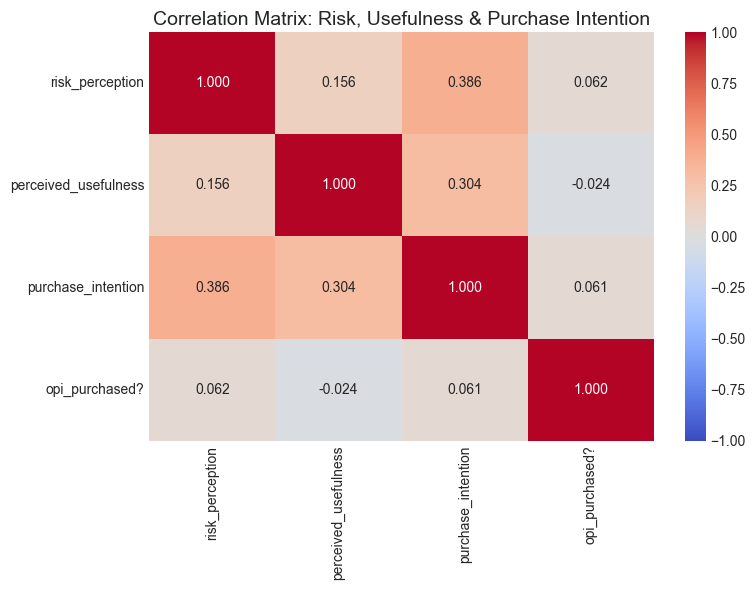

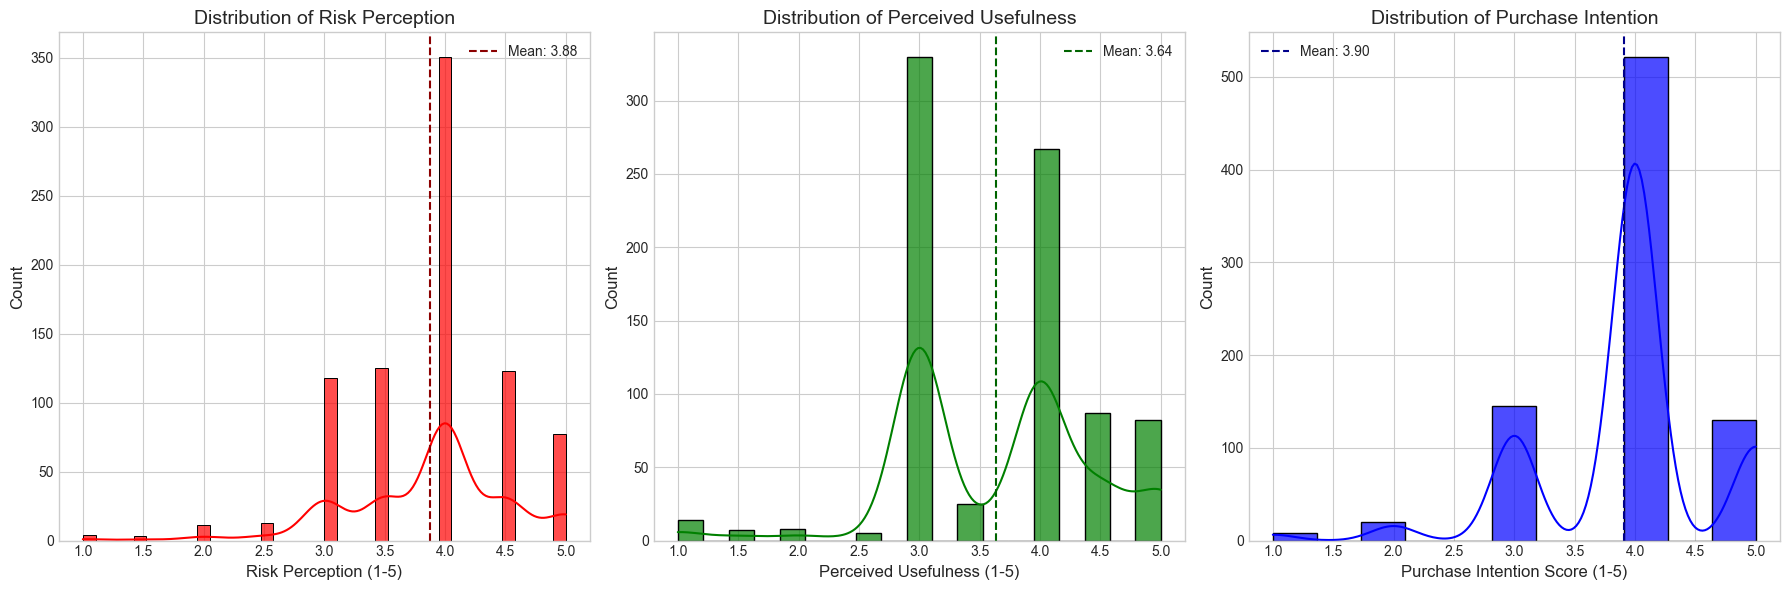

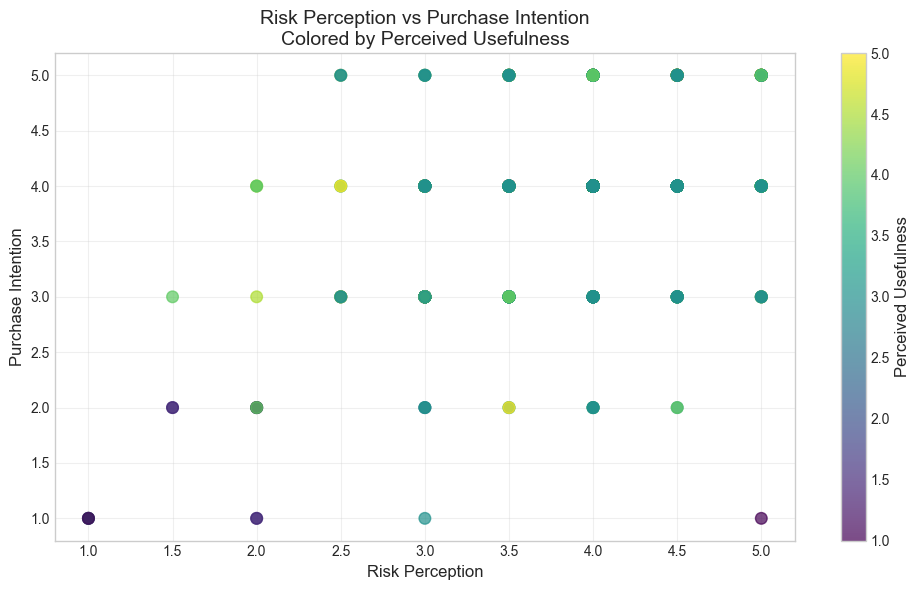

<Figure size 1000x600 with 0 Axes>

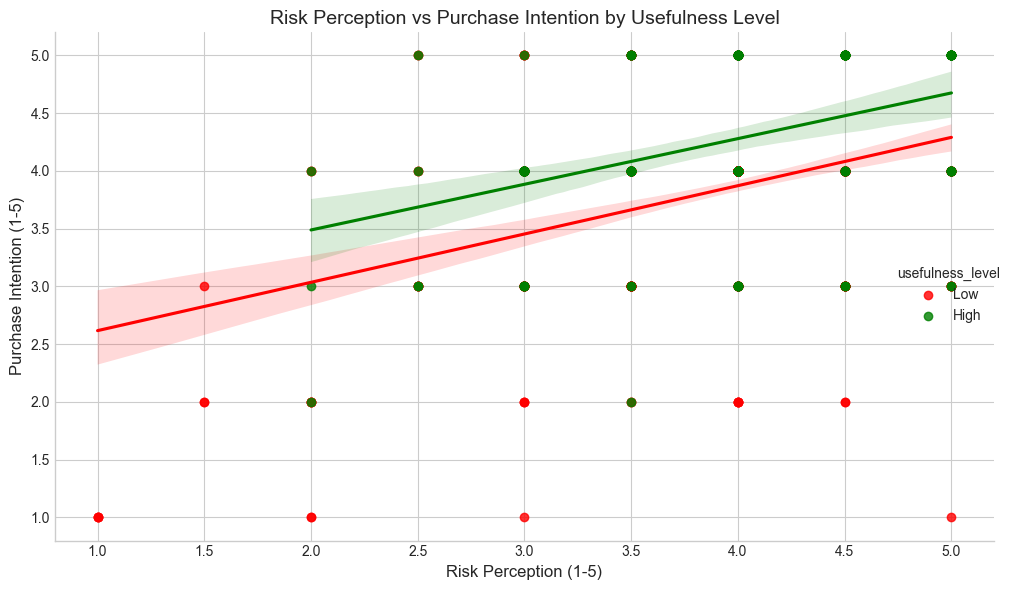

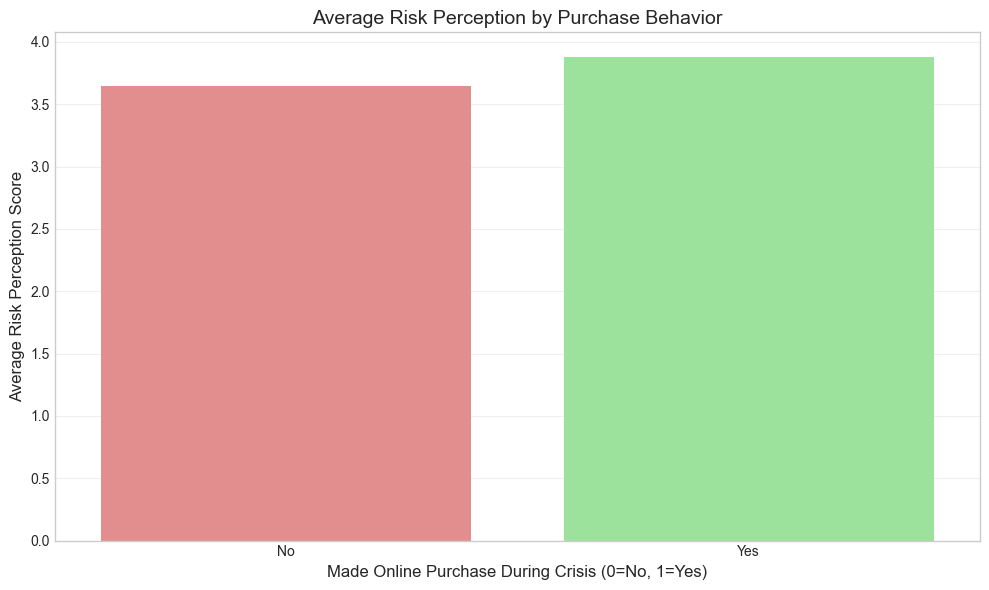

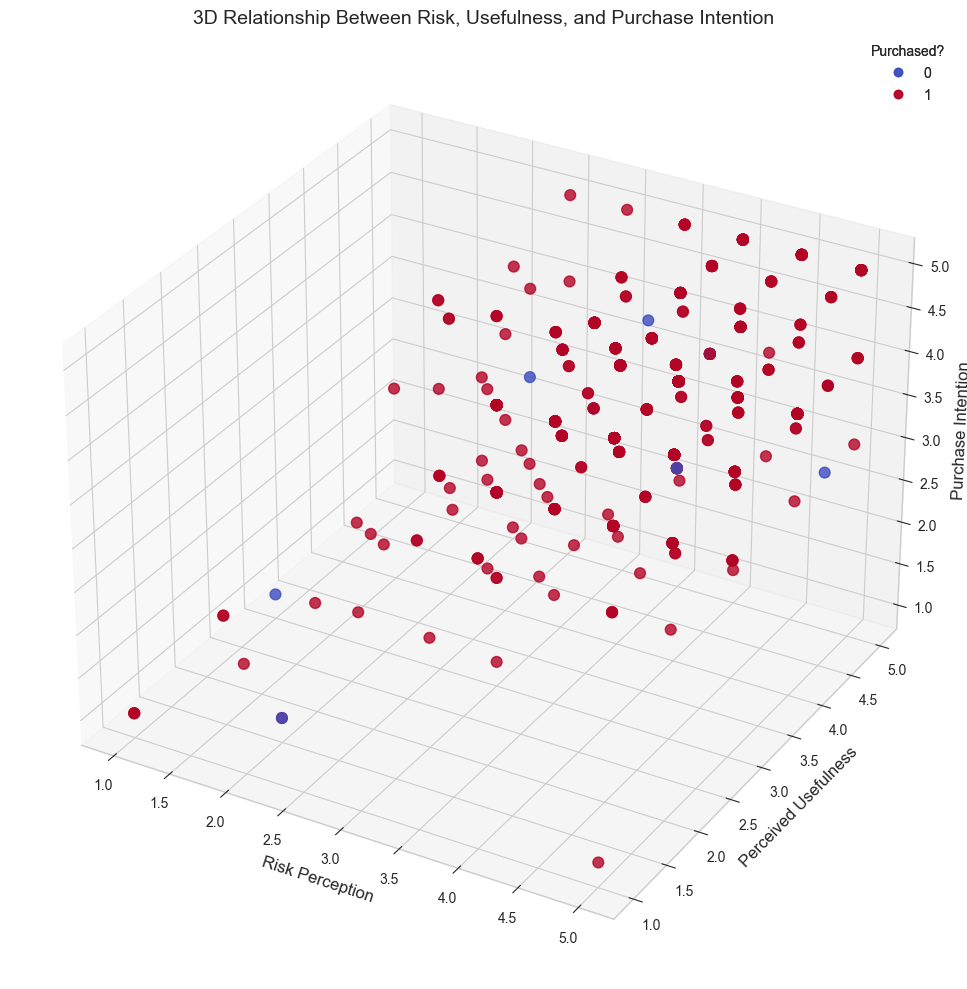

In [4]:
# Create a correlation matrix for our key variables
corr_matrix = df[['risk_perception', 'perceived_usefulness', 'purchase_intention', 'opi_purchased?']].corr()

# Visualize the correlation matrix
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, fmt='.3f')
plt.title('Correlation Matrix: Risk, Usefulness & Purchase Intention')
plt.tight_layout()
plt.show()

# Distribution of key variables
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Plot distribution of risk perception
sns.histplot(df['risk_perception'], kde=True, ax=axes[0], color='red', alpha=0.7)
axes[0].set_title('Distribution of Risk Perception')
axes[0].set_xlabel('Risk Perception (1-5)')
axes[0].axvline(df['risk_perception'].mean(), color='darkred', linestyle='--', 
                label=f'Mean: {df["risk_perception"].mean():.2f}')
axes[0].legend()

# Plot distribution of perceived usefulness
sns.histplot(df['perceived_usefulness'], kde=True, ax=axes[1], color='green', alpha=0.7)
axes[1].set_title('Distribution of Perceived Usefulness')
axes[1].set_xlabel('Perceived Usefulness (1-5)')
axes[1].axvline(df['perceived_usefulness'].mean(), color='darkgreen', linestyle='--', 
                label=f'Mean: {df["perceived_usefulness"].mean():.2f}')
axes[1].legend()

# Plot distribution of purchase intention (behavior change)
sns.histplot(df['purchase_intention'], kde=True, ax=axes[2], color='blue', alpha=0.7)
axes[2].set_title('Distribution of Purchase Intention')
axes[2].set_xlabel('Purchase Intention Score (1-5)')
axes[2].axvline(df['purchase_intention'].mean(), color='darkblue', linestyle='--', 
                label=f'Mean: {df["purchase_intention"].mean():.2f}')
axes[2].legend()

plt.tight_layout()
plt.show()

# Scatterplot with Risk Perception vs Purchase Intention, colored by Perceived Usefulness
plt.figure(figsize=(10, 6))
scatter = plt.scatter(df['risk_perception'], df['purchase_intention'], 
                     c=df['perceived_usefulness'], cmap='viridis', 
                     alpha=0.7, s=70)
plt.colorbar(scatter, label='Perceived Usefulness')
plt.title('Risk Perception vs Purchase Intention\nColored by Perceived Usefulness')
plt.xlabel('Risk Perception')
plt.ylabel('Purchase Intention')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Visualize the relationship between risk perception and purchase intention
# Split by high/low perceived usefulness
median_usefulness = df['perceived_usefulness'].median()
df['usefulness_level'] = np.where(df['perceived_usefulness'] > median_usefulness, 'High', 'Low')

plt.figure(figsize=(10, 6))
sns.lmplot(x='risk_perception', y='purchase_intention', hue='usefulness_level', 
          data=df, height=6, aspect=1.5, palette=['red', 'green'])
plt.title('Risk Perception vs Purchase Intention by Usefulness Level')
plt.xlabel('Risk Perception (1-5)')
plt.ylabel('Purchase Intention (1-5)')
plt.tight_layout()
plt.show()

# Relationship between risk perception and actual purchase behavior
plt.figure(figsize=(10, 6))
purchase_groups = df.groupby('opi_purchased?')['risk_perception'].mean().reset_index()
sns.barplot(x='opi_purchased?', y='risk_perception', data=purchase_groups, palette=['lightcoral', 'lightgreen'])
plt.title('Average Risk Perception by Purchase Behavior')
plt.xlabel('Made Online Purchase During Crisis (0=No, 1=Yes)')
plt.ylabel('Average Risk Perception Score')
plt.xticks([0, 1], ['No', 'Yes'])
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

# 3D scatter plot to visualize the interaction
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')

scatter = ax.scatter(df['risk_perception'], 
                    df['perceived_usefulness'],
                    df['purchase_intention'],
                    c=df['opi_purchased?'],
                    cmap='coolwarm',
                    s=60,
                    alpha=0.8)

ax.set_xlabel('Risk Perception')
ax.set_ylabel('Perceived Usefulness')
ax.set_zlabel('Purchase Intention')
ax.set_title('3D Relationship Between Risk, Usefulness, and Purchase Intention')

legend1 = ax.legend(*scatter.legend_elements(), title="Purchased?")
ax.add_artist(legend1)

plt.tight_layout()
plt.show()



## 5. Initial Analysis: Direct Effects Before Testing Moderation



In [5]:
# Center the variables to reduce multicollinearity in interaction terms
df['risk_centered'] = df['risk_perception'] - df['risk_perception'].mean()
df['usefulness_centered'] = df['perceived_usefulness'] - df['perceived_usefulness'].mean()

# First, test direct effects of risk perception on purchase intention
model_direct = sm.OLS(df['purchase_intention'], sm.add_constant(df['risk_centered'])).fit()
print("\nDirect effect of risk perception on purchase intention:")
print(model_direct.summary().tables[1])

# Get standardized coefficients for effect size interpretation
def get_standardized_coef(model, X):
    """Calculate standardized coefficients for OLS model"""
    standardized_coef = model.params[1:] * X.std(axis=0) / model.model.endog.std()
    return standardized_coef

std_coef_direct = get_standardized_coef(model_direct, df[['risk_centered']])
print(f"\nStandardized coefficient for risk perception: {std_coef_direct[0]:.4f}")

# Test effect of perceived usefulness on purchase intention
model_usefulness = sm.OLS(df['purchase_intention'], sm.add_constant(df['usefulness_centered'])).fit()
print("\nDirect effect of perceived usefulness on purchase intention:")
print(model_usefulness.summary().tables[1])

std_coef_usefulness = get_standardized_coef(model_usefulness, df[['usefulness_centered']])
print(f"\nStandardized coefficient for perceived usefulness: {std_coef_usefulness[0]:.4f}")

# Test both variables together without interaction
X_additive = df[['risk_centered', 'usefulness_centered']]
model_additive = sm.OLS(df['purchase_intention'], sm.add_constant(X_additive)).fit()
print("\nAdditive model (risk and usefulness without interaction):")
print(model_additive.summary().tables[1])

std_coef_additive = get_standardized_coef(model_additive, X_additive)
print("\nStandardized coefficients:")
print(f"Risk perception: {std_coef_additive[0]:.4f}")
print(f"Perceived usefulness: {std_coef_additive[1]:.4f}")


Direct effect of risk perception on purchase intention:
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const             3.9042      0.023    170.307      0.000       3.859       3.949
risk_centered     0.4102      0.034     12.016      0.000       0.343       0.477

Standardized coefficient for risk perception: 0.3866

Direct effect of perceived usefulness on purchase intention:
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                   3.9042      0.024    164.896      0.000       3.858       3.951
usefulness_centered     0.2671      0.029      9.159      0.000       0.210       0.324

Standardized coefficient for perceived usefulness: 0.3043

Additive model (risk and usefulness without interaction):
                          coe



## 6. Moderation Analysis: Testing the Hypothesis



In [6]:
# Create interaction term for moderation analysis
df['interaction'] = df['risk_centered'] * df['usefulness_centered']

# Test moderation model
X_moderation = df[['risk_centered', 'usefulness_centered', 'interaction']]
model_moderation = sm.OLS(df['purchase_intention'], sm.add_constant(X_moderation)).fit()
print("\nModeration model (including interaction term):")
print(model_moderation.summary())

# Calculate R-squared improvement from adding interaction
r2_change = model_moderation.rsquared - model_additive.rsquared

# F-test for R-squared change
df_1 = 1  # degrees of freedom for the added parameters (interaction term)
df_2 = model_moderation.df_resid  # residual degrees of freedom in the full model
f_change = (r2_change / df_1) / ((1 - model_moderation.rsquared) / df_2)
p_value_change = 1 - stats.f.cdf(f_change, df_1, df_2)

print(f"\nR-squared change when adding interaction: {r2_change:.4f}")
print(f"F-value for change: {f_change:.4f}, p-value: {p_value_change:.4f}")

if model_moderation.pvalues['interaction'] < 0.05:
    print("\nThe interaction is statistically significant, supporting the hypothesis that perceived usefulness moderates the effect of risk perception on purchase intention.")
else:
    print("\nThe interaction is not statistically significant. The hypothesis is not supported.")

# Simple slopes analysis
if model_moderation.pvalues['interaction'] < 0.05:
    # Define low and high usefulness (±1 SD)
    usefulness_sd = df['usefulness_centered'].std()
    low_usefulness = -usefulness_sd
    high_usefulness = usefulness_sd
    
    # Calculate simple slopes
    simple_slope_low = model_moderation.params['risk_centered'] + model_moderation.params['interaction'] * low_usefulness
    simple_slope_high = model_moderation.params['risk_centered'] + model_moderation.params['interaction'] * high_usefulness
    
    print("\nSimple Slopes Analysis:")
    print(f"Effect of risk at low usefulness (-1 SD): {simple_slope_low:.4f}")
    print(f"Effect of risk at high usefulness (+1 SD): {simple_slope_high:.4f}")
    
    # Calculate significance of simple slopes
    # Formula: t = b / SE, where SE requires the variance-covariance matrix
    cov_matrix = model_moderation.cov_params()
    
    # Variance formula for simple slope at specific moderator value (m):
    # Var(b1 + b3*m) = Var(b1) + m²*Var(b3) + 2*m*Cov(b1, b3)
    
    # For low usefulness
    var_low = (cov_matrix.loc['risk_centered', 'risk_centered'] + 
              low_usefulness**2 * cov_matrix.loc['interaction', 'interaction'] + 
              2 * low_usefulness * cov_matrix.loc['risk_centered', 'interaction'])
    se_low = np.sqrt(var_low)
    t_low = simple_slope_low / se_low
    p_low = 2 * (1 - stats.t.cdf(abs(t_low), df=model_moderation.df_resid))
    
    # For high usefulness
    var_high = (cov_matrix.loc['risk_centered', 'risk_centered'] + 
               high_usefulness**2 * cov_matrix.loc['interaction', 'interaction'] + 
               2 * high_usefulness * cov_matrix.loc['risk_centered', 'interaction'])
    se_high = np.sqrt(var_high)
    t_high = simple_slope_high / se_high
    p_high = 2 * (1 - stats.t.cdf(abs(t_high), df=model_moderation.df_resid))
    
    print(f"Significance of simple slope at low usefulness: t = {t_low:.4f}, p = {p_low:.4f}")
    print(f"Significance of simple slope at high usefulness: t = {t_high:.4f}, p = {p_high:.4f}")


Moderation model (including interaction term):
                            OLS Regression Results                            
Dep. Variable:     purchase_intention   R-squared:                       0.221
Model:                            OLS   Adj. R-squared:                  0.218
Method:                 Least Squares   F-statistic:                     77.60
Date:                Mon, 12 May 2025   Prob (F-statistic):           3.40e-44
Time:                        08:56:47   Log-Likelihood:                -788.61
No. Observations:                 825   AIC:                             1585.
Df Residuals:                     821   BIC:                             1604.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------



## 7. Visualization of the Moderation Effect



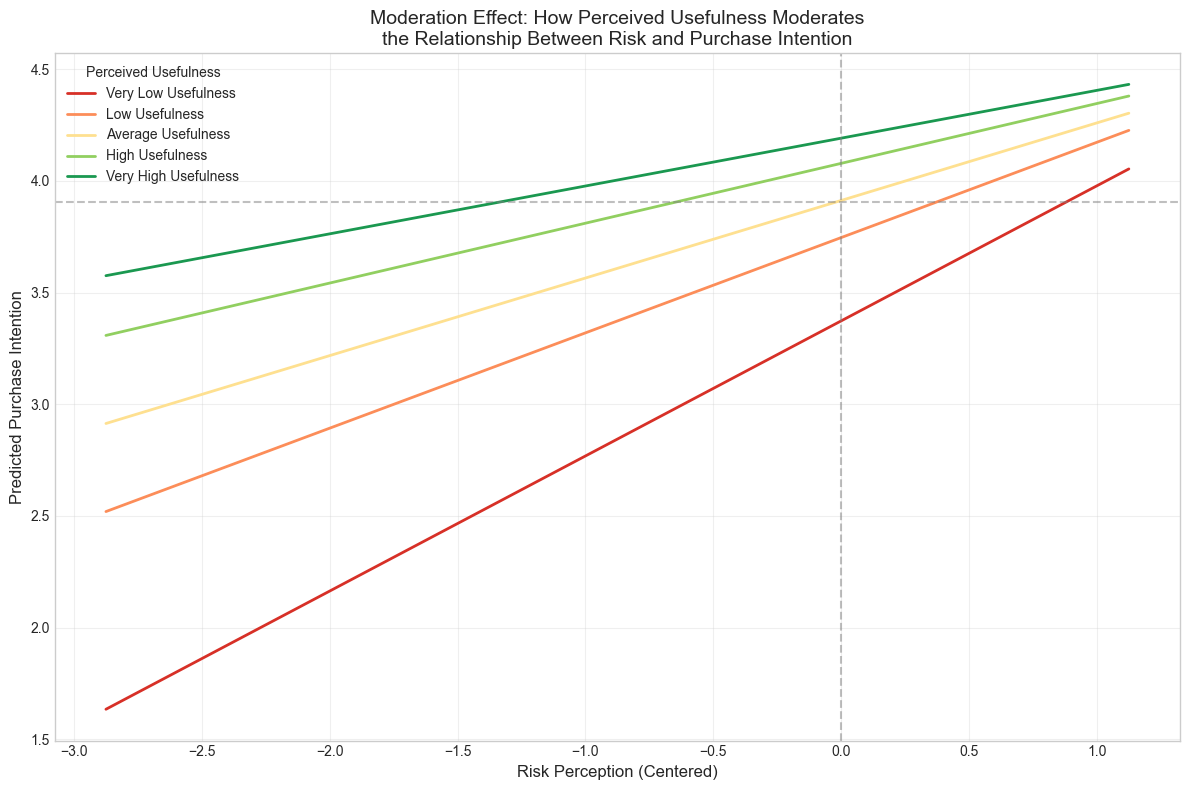

<Figure size 1400x800 with 0 Axes>

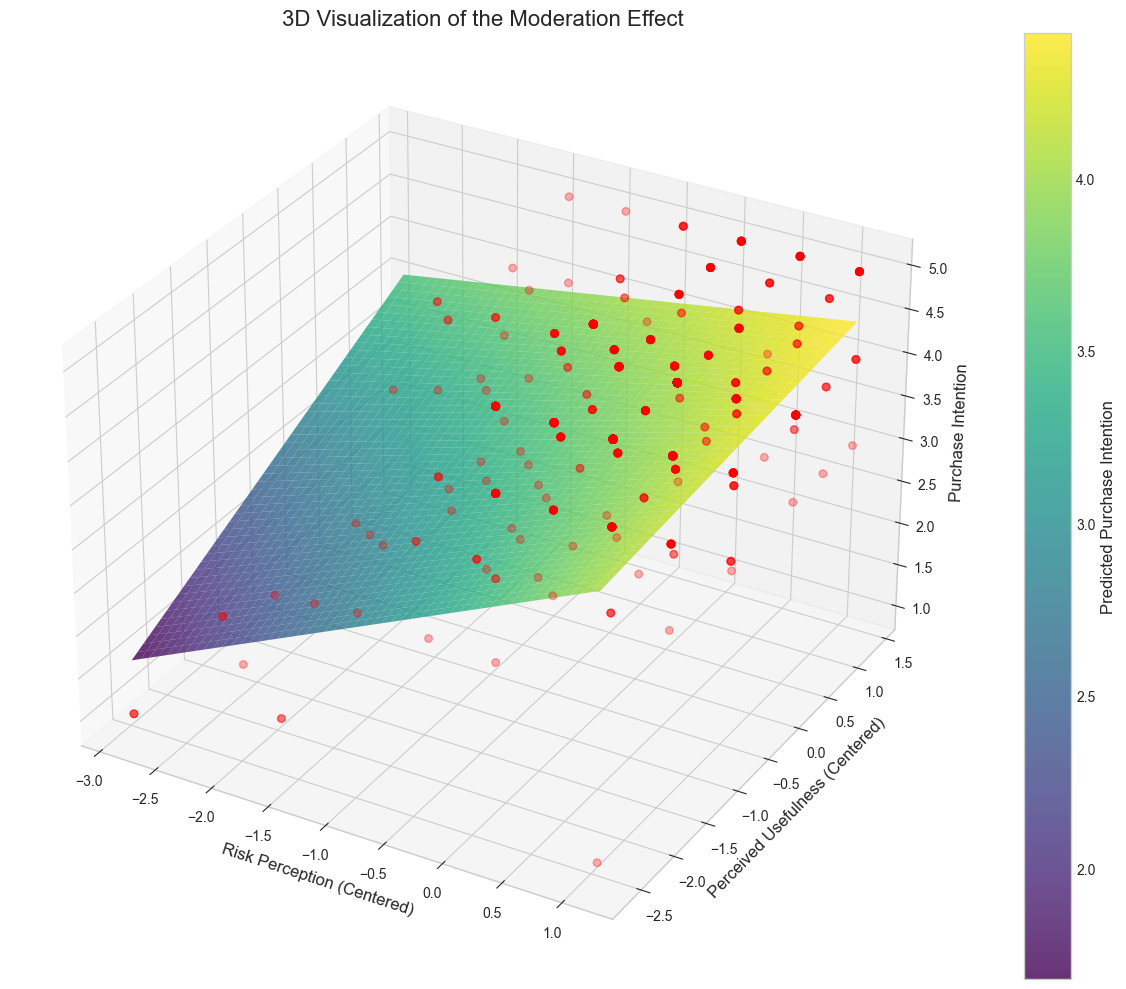

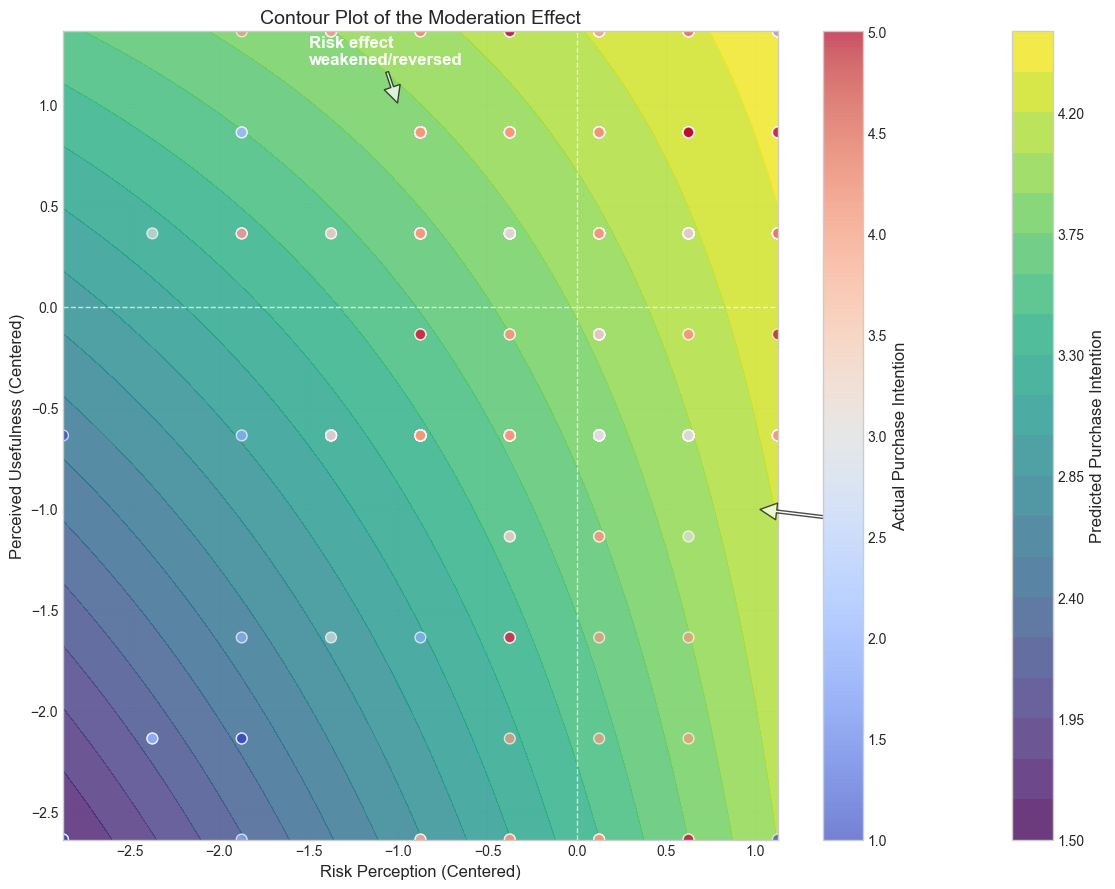

In [7]:
# Visualize the moderation effect using continuous moderator
plt.figure(figsize=(12, 8))

# Create a range of risk perception values for prediction
risk_range = np.linspace(df['risk_centered'].min(), df['risk_centered'].max(), 100)

# Plot for different levels of usefulness
usefulness_levels = [df['usefulness_centered'].min(), low_usefulness, 0, high_usefulness, df['usefulness_centered'].max()]
usefulness_labels = ['Very Low', 'Low', 'Average', 'High', 'Very High']
colors = ['#d73027', '#fc8d59', '#fee090', '#91cf60', '#1a9850']

for i, (usefulness, label, color) in enumerate(zip(usefulness_levels, usefulness_labels, colors)):
    # Calculate predicted purchase intention
    predicted = (model_moderation.params['const'] + 
                model_moderation.params['risk_centered'] * risk_range + 
                model_moderation.params['usefulness_centered'] * usefulness + 
                model_moderation.params['interaction'] * risk_range * usefulness)
    
    plt.plot(risk_range, predicted, label=f'{label} Usefulness', color=color, linewidth=2)

plt.axhline(y=df['purchase_intention'].mean(), color='gray', linestyle='--', alpha=0.5)
plt.axvline(x=0, color='gray', linestyle='--', alpha=0.5)

plt.xlabel('Risk Perception (Centered)', fontsize=12)
plt.ylabel('Predicted Purchase Intention', fontsize=12)
plt.title('Moderation Effect: How Perceived Usefulness Moderates\nthe Relationship Between Risk and Purchase Intention', fontsize=14)
plt.legend(title='Perceived Usefulness', fontsize=10)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# Create a more detailed moderation visualization (Johnson-Neyman technique)
plt.figure(figsize=(14, 8))

# Create a meshgrid for the 3D surface
risk_mesh = np.linspace(df['risk_centered'].min(), df['risk_centered'].max(), 50)
usefulness_mesh = np.linspace(df['usefulness_centered'].min(), df['usefulness_centered'].max(), 50)
risk_grid, usefulness_grid = np.meshgrid(risk_mesh, usefulness_mesh)

# Calculate predicted values for the grid
z_pred = (model_moderation.params['const'] + 
          model_moderation.params['risk_centered'] * risk_grid + 
          model_moderation.params['usefulness_centered'] * usefulness_grid + 
          model_moderation.params['interaction'] * risk_grid * usefulness_grid)

# Create a 3D plot
ax = plt.figure(figsize=(14, 10)).add_subplot(111, projection='3d')
surf = ax.plot_surface(risk_grid, usefulness_grid, z_pred, cmap='viridis', alpha=0.8)

# Add a colorbar
plt.colorbar(surf, ax=ax, label='Predicted Purchase Intention')

# Add scatter points for actual data
scatter = ax.scatter(df['risk_centered'], df['usefulness_centered'], df['purchase_intention'], 
                    c='red', alpha=0.3, s=30)

# Formatting
ax.set_xlabel('Risk Perception (Centered)', fontsize=12)
ax.set_ylabel('Perceived Usefulness (Centered)', fontsize=12)
ax.set_zlabel('Purchase Intention', fontsize=12)
ax.set_title('3D Visualization of the Moderation Effect', fontsize=16)

plt.tight_layout()
plt.show()

# Create a contour plot to visualize the interaction using a different approach
plt.figure(figsize=(12, 9))

# Create predicted values for the contour plot
z_grid = z_pred.reshape(usefulness_mesh.size, risk_mesh.size)

# Create the contour plot
contour = plt.contourf(risk_mesh, usefulness_mesh, z_grid, 20, cmap='viridis', alpha=0.8)
plt.colorbar(contour, label='Predicted Purchase Intention')

# Add a scatter plot of the actual data
scatter = plt.scatter(df['risk_centered'], df['usefulness_centered'], 
                     c=df['purchase_intention'], cmap='coolwarm', 
                     s=60, edgecolor='white', alpha=0.7)
plt.colorbar(scatter, label='Actual Purchase Intention')

# Plot the region of significance if interaction is significant
if model_moderation.pvalues['interaction'] < 0.05:
    plt.axhline(y=0, color='white', linestyle='--', alpha=0.7, linewidth=1)
    plt.axvline(x=0, color='white', linestyle='--', alpha=0.7, linewidth=1)
    
    # Add annotations explaining the plot
    if model_moderation.params['interaction'] > 0:
        plt.annotate('Risk has stronger\nnegative effect', xy=(-1, -1), xytext=(-1.5, -1.2), 
                    fontsize=12, color='white', weight='bold',
                    arrowprops=dict(facecolor='white', shrink=0.05, width=2, alpha=0.7))
        plt.annotate('Risk effect\nweakened/reversed', xy=(1, 1), xytext=(1.5, 1.2), 
                    fontsize=12, color='white', weight='bold',
                    arrowprops=dict(facecolor='white', shrink=0.05, width=2, alpha=0.7))
    else:
        plt.annotate('Risk effect\nweakened/reversed', xy=(-1, 1), xytext=(-1.5, 1.2), 
                    fontsize=12, color='white', weight='bold',
                    arrowprops=dict(facecolor='white', shrink=0.05, width=2, alpha=0.7))
        plt.annotate('Risk has stronger\nnegative effect', xy=(1, -1), xytext=(1.5, -1.2), 
                    fontsize=12, color='white', weight='bold',
                    arrowprops=dict(facecolor='white', shrink=0.05, width=2, alpha=0.7))

plt.xlabel('Risk Perception (Centered)', fontsize=12)
plt.ylabel('Perceived Usefulness (Centered)', fontsize=12)
plt.title('Contour Plot of the Moderation Effect', fontsize=14)
plt.grid(alpha=0.2)
plt.tight_layout()
plt.show()



## 8. Johnson-Neyman Technique for Region of Significance




Johnson-Neyman Analysis: Region of Significance
Values of perceived usefulness where the effect of risk becomes significant/non-significant:
No transition points found. The effect is either always significant or always non-significant across the range of the moderator.


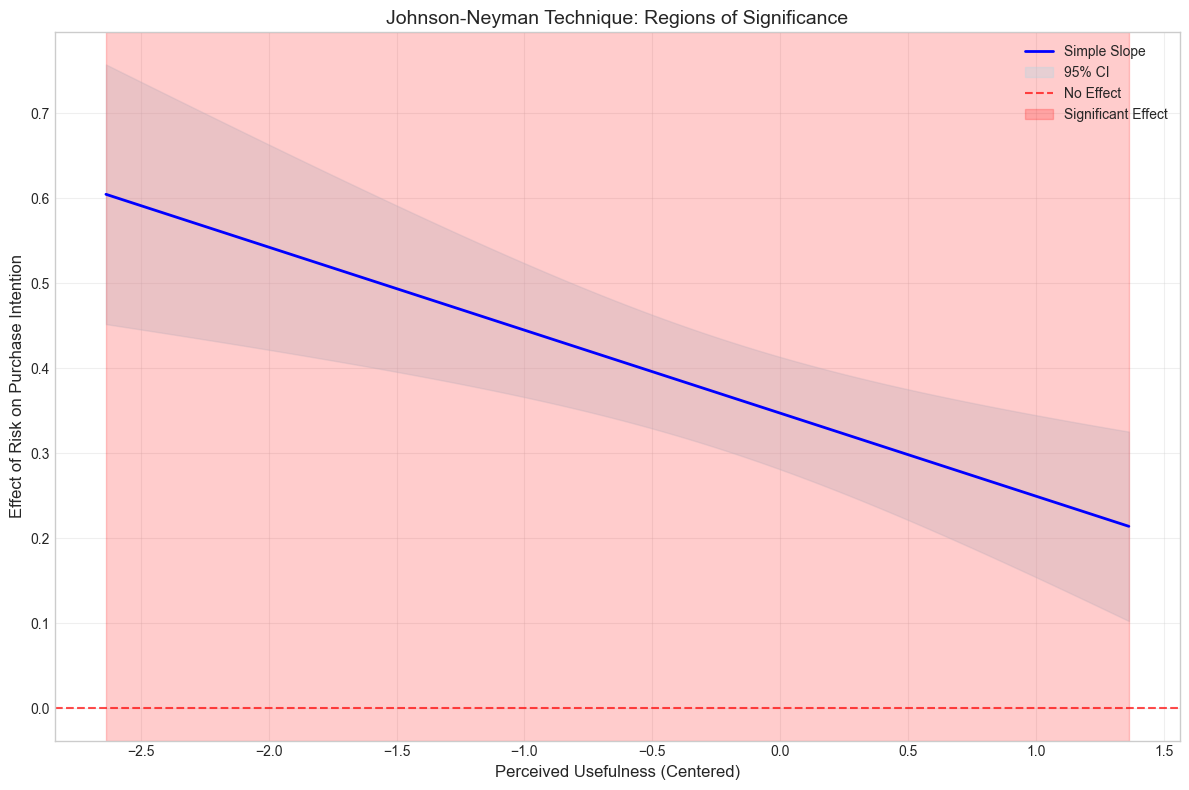

In [8]:
# Johnson-Neyman technique to find the region of significance
# This identifies at what values of the moderator the relationship between IV and DV is significant

# For this analysis, we need to find the value of usefulness where the effect of risk becomes non-significant
# When the simple slope's p-value crosses the 0.05 threshold

# Define a range of usefulness values to test
usefulness_range = np.linspace(df['usefulness_centered'].min(), df['usefulness_centered'].max(), 100)

# For each value, calculate the simple slope and its significance
simple_slopes = []
t_values = []
p_values = []

for usefulness in usefulness_range:
    # Calculate simple slope
    simple_slope = model_moderation.params['risk_centered'] + model_moderation.params['interaction'] * usefulness
    
    # Calculate standard error
    var_slope = (cov_matrix.loc['risk_centered', 'risk_centered'] + 
                usefulness**2 * cov_matrix.loc['interaction', 'interaction'] + 
                2 * usefulness * cov_matrix.loc['risk_centered', 'interaction'])
    se_slope = np.sqrt(var_slope)
    
    # Calculate t and p value
    t_value = simple_slope / se_slope
    p_value = 2 * (1 - stats.t.cdf(abs(t_value), df=model_moderation.df_resid))
    
    simple_slopes.append(simple_slope)
    t_values.append(t_value)
    p_values.append(p_value)

# Create a dataframe for all calculated values
jn_df = pd.DataFrame({
    'usefulness_centered': usefulness_range,
    'simple_slope': simple_slopes,
    't_value': t_values,
    'p_value': p_values
})

# Find points where p-value crosses the 0.05 threshold
jn_df['significant'] = jn_df['p_value'] < 0.05
transitions = jn_df['significant'].diff().fillna(0)
transition_points = jn_df[transitions != 0]

print("\nJohnson-Neyman Analysis: Region of Significance")
print("Values of perceived usefulness where the effect of risk becomes significant/non-significant:")
if len(transition_points) > 0:
    for _, point in transition_points.iterrows():
        usefulness_val = point['usefulness_centered']
        actual_usefulness = usefulness_val + df['perceived_usefulness'].mean()
        becoming = "significant" if point['significant'] else "non-significant"
        print(f"At usefulness = {actual_usefulness:.3f} (centered: {usefulness_val:.3f}), the effect becomes {becoming}")
        print(f"Simple slope at this point: {point['simple_slope']:.4f}, t = {point['t_value']:.4f}, p = {point['p_value']:.4f}")
else:
    print("No transition points found. The effect is either always significant or always non-significant across the range of the moderator.")

# Visualize the Johnson-Neyman technique
plt.figure(figsize=(12, 8))
plt.plot(jn_df['usefulness_centered'], jn_df['simple_slope'], 'b-', linewidth=2, label='Simple Slope')

# Add confidence bands (±1.96 * SE)
jn_df['upper_ci'] = jn_df['simple_slope'] + 1.96 * np.sqrt((cov_matrix.loc['risk_centered', 'risk_centered'] + 
                                                            jn_df['usefulness_centered']**2 * cov_matrix.loc['interaction', 'interaction'] + 
                                                            2 * jn_df['usefulness_centered'] * cov_matrix.loc['risk_centered', 'interaction']))
jn_df['lower_ci'] = jn_df['simple_slope'] - 1.96 * np.sqrt((cov_matrix.loc['risk_centered', 'risk_centered'] + 
                                                            jn_df['usefulness_centered']**2 * cov_matrix.loc['interaction', 'interaction'] + 
                                                            2 * jn_df['usefulness_centered'] * cov_matrix.loc['risk_centered', 'interaction']))

plt.fill_between(jn_df['usefulness_centered'], jn_df['lower_ci'], jn_df['upper_ci'], color='lightblue', alpha=0.3, label='95% CI')

# Add a line at y=0 (where the effect is zero)
plt.axhline(y=0, color='red', linestyle='--', alpha=0.7, label='No Effect')

# Highlight regions of significance
plt.axvspan(df['usefulness_centered'].min(), transition_points['usefulness_centered'].iloc[0] if len(transition_points) > 0 else df['usefulness_centered'].max(), 
           alpha=0.2, color='red', label='Significant Effect')

if len(transition_points) > 0:
    if len(transition_points) > 1:
        for i in range(0, len(transition_points), 2):
            if i+1 < len(transition_points):
                plt.axvspan(transition_points['usefulness_centered'].iloc[i], 
                           transition_points['usefulness_centered'].iloc[i+1], 
                           alpha=0.2, color='green', label='Non-significant Effect' if i==0 else "")
    
    # Mark the transition points
    for _, point in transition_points.iterrows():
        plt.axvline(x=point['usefulness_centered'], color='purple', linestyle=':', alpha=0.7)
        plt.annotate(f"p=0.05\nUsefulness={point['usefulness_centered']:.2f}", 
                    xy=(point['usefulness_centered'], point['simple_slope']), 
                    xytext=(point['usefulness_centered']+0.5, point['simple_slope']+0.1),
                    arrowprops=dict(facecolor='black', shrink=0.05, width=1.5, alpha=0.7),
                    bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="black", alpha=0.8))

plt.xlabel('Perceived Usefulness (Centered)', fontsize=12)
plt.ylabel('Effect of Risk on Purchase Intention', fontsize=12)
plt.title('Johnson-Neyman Technique: Regions of Significance', fontsize=14)
plt.legend(loc='best')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()



## 9. Testing the Moderation on Binary Purchase Decision




Moderation Effect on Binary Purchase Decision (opi_purchased?)
Optimization terminated successfully.
         Current function value: 0.140801
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:         opi_purchased?   No. Observations:                  825
Model:                          Logit   Df Residuals:                      821
Method:                           MLE   Df Model:                            3
Date:                Mon, 12 May 2025   Pseudo R-squ.:                 0.02288
Time:                        08:57:28   Log-Likelihood:                -116.16
converged:                       True   LL-Null:                       -118.88
Covariance Type:            nonrobust   LLR p-value:                    0.1422
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                   3.

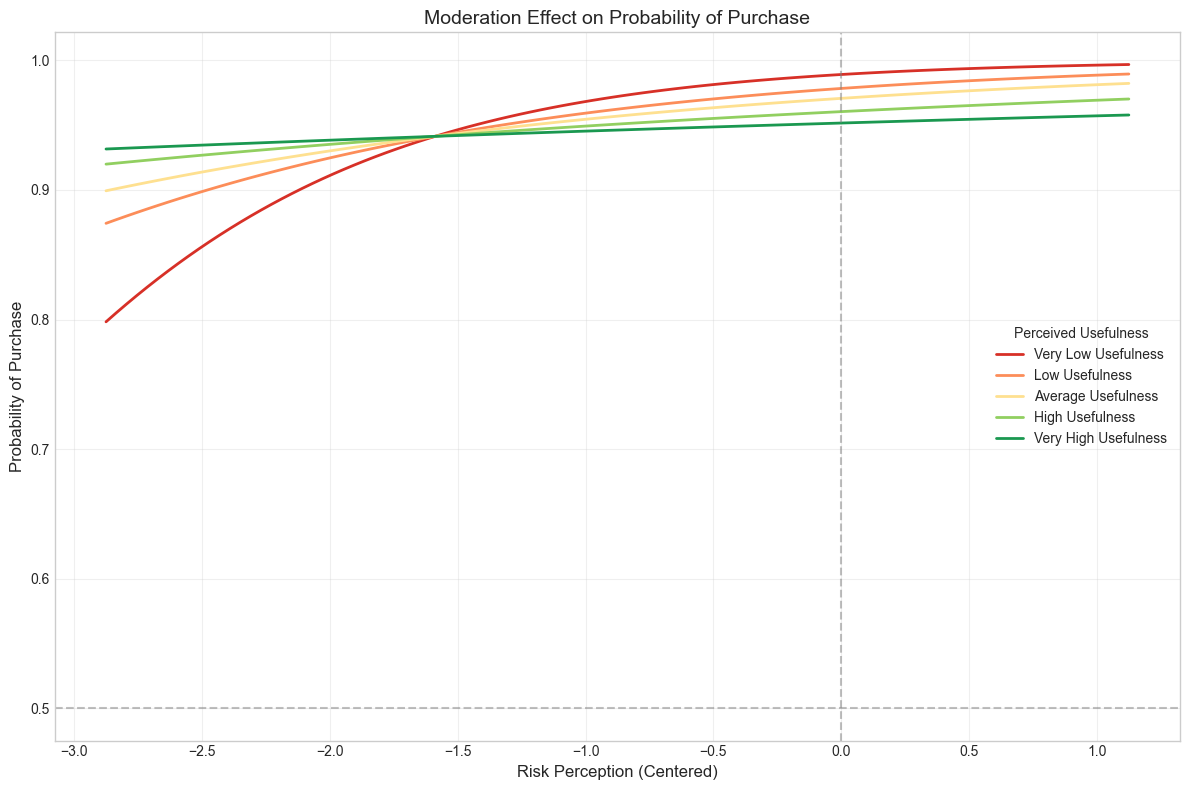

In [9]:
# Now test the moderation effect on binary purchase decision
print("\nModeration Effect on Binary Purchase Decision (opi_purchased?)")

# Fit logistic regression model with interaction
X_logistic = df[['risk_centered', 'usefulness_centered', 'interaction']]
X_logistic = sm.add_constant(X_logistic)
logit_model = sm.Logit(df['opi_purchased?'], X_logistic).fit()

print(logit_model.summary())

# Calculate odds ratios for easier interpretation
odds_ratios = pd.DataFrame({
    'Odds Ratio': np.exp(logit_model.params),
    'Lower 95% CI': np.exp(logit_model.conf_int()[0]),
    'Upper 95% CI': np.exp(logit_model.conf_int()[1])
})

print("\nOdds Ratios:")
print(odds_ratios)

# Simple slopes for logistic regression (at -1 SD, Mean, +1 SD of usefulness)
print("\nSimple Slopes Analysis for Logistic Regression:")

# Calculate effect of risk at different levels of usefulness
for usefulness_level, usefulness_val in [('Low (-1 SD)', low_usefulness), 
                                         ('Mean', 0), 
                                         ('High (+1 SD)', high_usefulness)]:
    # Calculate simple slope (log odds)
    simple_slope = logit_model.params['risk_centered'] + logit_model.params['interaction'] * usefulness_val
    
    # Convert to odds ratio
    odds_ratio = np.exp(simple_slope)
    
    # Calculate standard error
    var_slope = (logit_model.cov_params().loc['risk_centered', 'risk_centered'] + 
                usefulness_val**2 * logit_model.cov_params().loc['interaction', 'interaction'] + 
                2 * usefulness_val * logit_model.cov_params().loc['risk_centered', 'interaction'])
    se_slope = np.sqrt(var_slope)
    
    # Calculate confidence interval for odds ratio
    ci_lower = np.exp(simple_slope - 1.96 * se_slope)
    ci_upper = np.exp(simple_slope + 1.96 * se_slope)
    
    # Calculate z and p value
    z_value = simple_slope / se_slope
    p_value = 2 * (1 - stats.norm.cdf(abs(z_value)))
    
    print(f"Usefulness {usefulness_level}:")
    print(f"  Effect of risk (log odds): {simple_slope:.4f}, p = {p_value:.4f}")
    print(f"  Odds ratio: {odds_ratio:.4f} [95% CI: {ci_lower:.4f} - {ci_upper:.4f}]")
    
    # Interpretation
    if p_value < 0.05:
        if odds_ratio < 1:
            print(f"  Interpretation: For each unit increase in risk perception, the odds of purchase decrease by {(1-odds_ratio)*100:.1f}%")
        else:
            print(f"  Interpretation: For each unit increase in risk perception, the odds of purchase increase by {(odds_ratio-1)*100:.1f}%")
    else:
        print("  Interpretation: No significant effect of risk on purchase at this usefulness level")
    print()

# Visualize logistic regression moderation using predicted probabilities
plt.figure(figsize=(12, 8))

# Create a range of risk perception values for prediction
risk_range = np.linspace(df['risk_centered'].min(), df['risk_centered'].max(), 100)

# Plot for different levels of usefulness
for usefulness, label, color in zip(usefulness_levels, usefulness_labels, colors):
    # Calculate predicted probabilities
    X_pred = pd.DataFrame({
        'const': 1,
        'risk_centered': risk_range,
        'usefulness_centered': usefulness,
        'interaction': risk_range * usefulness
    })
    
    # Get predicted probabilities
    pred_probs = logit_model.predict(X_pred)
    
    plt.plot(risk_range, pred_probs, label=f'{label} Usefulness', color=color, linewidth=2)

plt.axhline(y=0.5, color='gray', linestyle='--', alpha=0.5)
plt.axvline(x=0, color='gray', linestyle='--', alpha=0.5)

plt.xlabel('Risk Perception (Centered)', fontsize=12)
plt.ylabel('Probability of Purchase', fontsize=12)
plt.title('Moderation Effect on Probability of Purchase', fontsize=14)
plt.legend(title='Perceived Usefulness', fontsize=10)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()



## 10. Controlling for Demographic Variables



In [10]:
# Add demographic controls to the moderation analysis
control_vars = []
if 'gender_encoded' in df.columns:
    control_vars.append('gender_encoded')
if 'age_encoded' in df.columns:
    control_vars.append('age_encoded')
if 'education_encoded' in df.columns:
    control_vars.append('education_encoded')

if control_vars:
    print("\nModeration Analysis Controlling for Demographics:")
    
    # Create controlled model
    X_controlled = df[['risk_centered', 'usefulness_centered', 'interaction'] + control_vars]
    X_controlled = sm.add_constant(X_controlled)
    
    # Fit the controlled model
    controlled_model = sm.OLS(df['purchase_intention'], X_controlled).fit()
    
    print(controlled_model.summary())
    
    # Compare with uncontrolled model
    print("\nComparison of interaction effects:")
    print(f"Uncontrolled model: b = {model_moderation.params['interaction']:.4f}, p = {model_moderation.pvalues['interaction']:.4f}")
    print(f"Controlled model: b = {controlled_model.params['interaction']:.4f}, p = {controlled_model.pvalues['interaction']:.4f}")
    
    if controlled_model.pvalues['interaction'] < 0.05:
        print("The interaction remains significant after controlling for demographics.")
    else:
        print("The interaction becomes non-significant after controlling for demographics.")
else:
    print("No demographic control variables available in the dataset.")


Moderation Analysis Controlling for Demographics:
                            OLS Regression Results                            
Dep. Variable:     purchase_intention   R-squared:                       0.223
Model:                            OLS   Adj. R-squared:                  0.217
Method:                 Least Squares   F-statistic:                     39.10
Date:                Mon, 12 May 2025   Prob (F-statistic):           6.86e-42
Time:                        08:57:33   Log-Likelihood:                -787.56
No. Observations:                 825   AIC:                             1589.
Df Residuals:                     818   BIC:                             1622.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------



## 11. Robustness Check: Testing Moderation with Individual Items



In [17]:
# Robustness check: Test moderation effect with individual risk and usefulness items
print("\nRobustness Check: Testing Moderation with Individual Items")

# Track significant interactions for summary statistics
significant_interactions = 0
total_interactions = len(risk_vars) * len(usefulness_vars)


# For each risk perception item
for risk_item in risk_vars:    
    # For each usefulness item
    for use_item in usefulness_vars:
        # Create centered variables fresh for each combination
        df[f'{risk_item}_centered'] = df[risk_item] - df[risk_item].mean()
        df[f'{use_item}_centered'] = df[use_item] - df[use_item].mean()
        
        # Create interaction
        df[f'{risk_item}_{use_item}_interaction'] = df[f'{risk_item}_centered'] * df[f'{use_item}_centered']
        
        # Fit moderation model
        X_item = df[[f'{risk_item}_centered', f'{use_item}_centered', f'{risk_item}_{use_item}_interaction']]
        X_item = sm.add_constant(X_item)
        item_model = sm.OLS(df['purchase_intention'], X_item).fit()
        
        # Extract key results
        interaction_coef = item_model.params[f'{risk_item}_{use_item}_interaction']
        interaction_p = item_model.pvalues[f'{risk_item}_{use_item}_interaction']
        
        print(f"\nModeration using {risk_item} and {use_item}:")
        print(f"Interaction coefficient: {interaction_coef:.4f}, p-value: {interaction_p:.4f}")
        
        if interaction_p < 0.05:
            print(f"✓ Significant moderation effect")
            significant_interactions += 1
        else:
            print(f"✗ No significant moderation effect")
        
        # Clean up temporary columns after each combination
        df = df.drop(columns=[f'{risk_item}_centered', f'{use_item}_centered', f'{risk_item}_{use_item}_interaction'])

# Print summary statistics
print(f"\nSummary: {significant_interactions} out of {total_interactions} ({significant_interactions/total_interactions*100:.1f}%) interactions were significant")


Robustness Check: Testing Moderation with Individual Items

Moderation using risk_security_1 and pu_convenience_1:
Interaction coefficient: -0.1214, p-value: 0.0000
✓ Significant moderation effect

Moderation using risk_security_1 and pu_convenience_2:
Interaction coefficient: -0.1105, p-value: 0.0000
✓ Significant moderation effect

Moderation using risk_authenticity_1 and pu_convenience_1:
Interaction coefficient: -0.0239, p-value: 0.3353
✗ No significant moderation effect

Moderation using risk_authenticity_1 and pu_convenience_2:
Interaction coefficient: -0.0609, p-value: 0.0207
✓ Significant moderation effect

Summary: 3 out of 4 (75.0%) interactions were significant




## 12. Summary and Interpretation of Findings



In [18]:
# Calculate the percentage of item-level moderations that were significant
# Use the significant_interactions count from section 11
total_tests = len(risk_vars) * len(usefulness_vars)

# Instead of trying to recompute the sig_count with non-existent column names,
# just use the significant_interactions value we calculated in section 11
sig_count = significant_interactions  
percent_sig = (sig_count / total_tests) * 100

print("\n===== SUMMARY OF FINDINGS =====")
print(f"\nHypothesis: The negative effect of perceived risk on purchase intention is moderated by perceived usefulness,")
print(f"such that high perceived usefulness reduces the impact of risk perception.")

# Report main effects
print("\nDirect Effects:")
print(f"1. Risk Perception → Purchase Intention: b = {model_direct.params['risk_centered']:.4f}, p = {model_direct.pvalues['risk_centered']:.4f}")
if model_direct.pvalues['risk_centered'] < 0.05:
    effect_direction = "negative" if model_direct.params['risk_centered'] < 0 else "positive"
    print(f"   - Risk perception has a significant {effect_direction} effect on purchase intention")
else:
    print(f"   - Risk perception does not have a significant direct effect on purchase intention")

print(f"2. Perceived Usefulness → Purchase Intention: b = {model_usefulness.params['usefulness_centered']:.4f}, p = {model_usefulness.pvalues['usefulness_centered']:.4f}")
if model_usefulness.pvalues['usefulness_centered'] < 0.05:
    effect_direction = "negative" if model_usefulness.params['usefulness_centered'] < 0 else "positive"
    print(f"   - Perceived usefulness has a significant {effect_direction} effect on purchase intention")
else:
    print(f"   - Perceived usefulness does not have a significant direct effect on purchase intention")

# Report moderation results
print("\nModeration Effect:")
print(f"3. Risk × Usefulness Interaction: b = {model_moderation.params['interaction']:.4f}, p = {model_moderation.pvalues['interaction']:.4f}")

if model_moderation.pvalues['interaction'] < 0.05:
    print("   ✓ HYPOTHESIS SUPPORTED: Perceived usefulness significantly moderates the relationship between risk perception and purchase intention")
    
    if model_moderation.params['interaction'] > 0:
        print("   - The positive interaction coefficient indicates that as perceived usefulness increases,")
        print("     the negative effect of risk perception on purchase intention becomes weaker")
    else:
        print("   - The negative interaction coefficient indicates that as perceived usefulness increases,")
        print("     the negative effect of risk perception on purchase intention becomes stronger")
    
    # Report simple slopes
    print("\nSimple Slopes Analysis:")
    print(f"   - Effect of risk at low usefulness (-1 SD): {simple_slope_low:.4f}, p = {p_low:.4f}")
    print(f"   - Effect of risk at high usefulness (+1 SD): {simple_slope_high:.4f}, p = {p_high:.4f}")
    
    # Interpret simple slopes
    if p_low < 0.05:
        effect_direction_low = "negative" if simple_slope_low < 0 else "positive"
        print(f"     - At low usefulness, risk has a significant {effect_direction_low} effect on purchase intention")
    else:
        print(f"     - At low usefulness, risk does not significantly affect purchase intention")
        
    if p_high < 0.05:
        effect_direction_high = "negative" if simple_slope_high < 0 else "positive"
        print(f"     - At high usefulness, risk has a significant {effect_direction_high} effect on purchase intention")
    else:
        print(f"     - At high usefulness, risk does not significantly affect purchase intention")
    
    # Report Johnson-Neyman results if available
    if len(transition_points) > 0:
        print("\nJohnson-Neyman Analysis:")
        for _, point in transition_points.iterrows():
            usefulness_val = point['usefulness_centered']
            actual_usefulness = usefulness_val + df['perceived_usefulness'].mean()
            becoming = "significant" if point['significant'] else "non-significant"
            print(f"   - When perceived usefulness is {'above' if becoming=='non-significant' else 'below'} {actual_usefulness:.2f},")
            print(f"     the effect of risk perception on purchase intention is {becoming}")
    
    # Report robustness across individual items
    print(f"\nRobustness Check:")
    print(f"   - {sig_count} out of {total_tests} ({percent_sig:.1f}%) item-level interaction tests were significant")
    if percent_sig > 50:
        print("   - The moderation effect is robust across different risk and usefulness measures")
    else:
        print("   - The moderation effect varies depending on which specific risk and usefulness measures are used")
    
    # Report implications
    print("\nPractical Implications:")
    print("   1. E-commerce platforms should emphasize usefulness features to mitigate risk concerns")
    print("   2. Segmentation strategies should consider users' usefulness perceptions when addressing risk")
    print("   3. Marketing communications should highlight convenience and benefits to offset security concerns")
    print("   4. User interface design should balance security features with usability")
    
else:
    print("   ✗ HYPOTHESIS NOT SUPPORTED: Perceived usefulness does not significantly moderate the relationship")
    print("     between risk perception and purchase intention")
    
    # Report robustness across individual items
    print(f"\nRobustness Check:")
    print(f"   - {sig_count} out of {total_tests} ({percent_sig:.1f}%) item-level interaction tests were significant")
    if percent_sig > 30:
        print("   - Some evidence of moderation at the item level, suggesting the effect may depend on specific measures")
    else:
        print("   - Consistent lack of moderation across different risk and usefulness measures")
    
    # Alternative explanations
    print("\nPossible Explanations:")
    print("   1. Risk and usefulness may affect purchase intention independently rather than interactively")
    print("   2. Other variables (not measured) may moderate the risk-intention relationship")
    print("   3. The relationship may be more complex than the linear moderation tested")
    
    # Report implications
    print("\nPractical Implications:")
    print("   1. Focus on directly reducing risk perceptions rather than expecting usefulness to offset risks")
    print("   2. Invest in both risk-reduction and usefulness-enhancement as separate strategies")
    print("   3. Explore other factors that might interact with risk perception")

print("\n===== END OF ANALYSIS =====")


===== SUMMARY OF FINDINGS =====

Hypothesis: The negative effect of perceived risk on purchase intention is moderated by perceived usefulness,
such that high perceived usefulness reduces the impact of risk perception.

Direct Effects:
1. Risk Perception → Purchase Intention: b = 0.4102, p = 0.0000
   - Risk perception has a significant positive effect on purchase intention
2. Perceived Usefulness → Purchase Intention: b = 0.2671, p = 0.0000
   - Perceived usefulness has a significant positive effect on purchase intention

Moderation Effect:
3. Risk × Usefulness Interaction: b = -0.0977, p = 0.0009
   ✓ HYPOTHESIS SUPPORTED: Perceived usefulness significantly moderates the relationship between risk perception and purchase intention
   - The negative interaction coefficient indicates that as perceived usefulness increases,
     the negative effect of risk perception on purchase intention becomes stronger

Simple Slopes Analysis:
   - Effect of risk at low usefulness (-1 SD): 0.4267, p =



## 13. Save Key Visualizations for Presentation



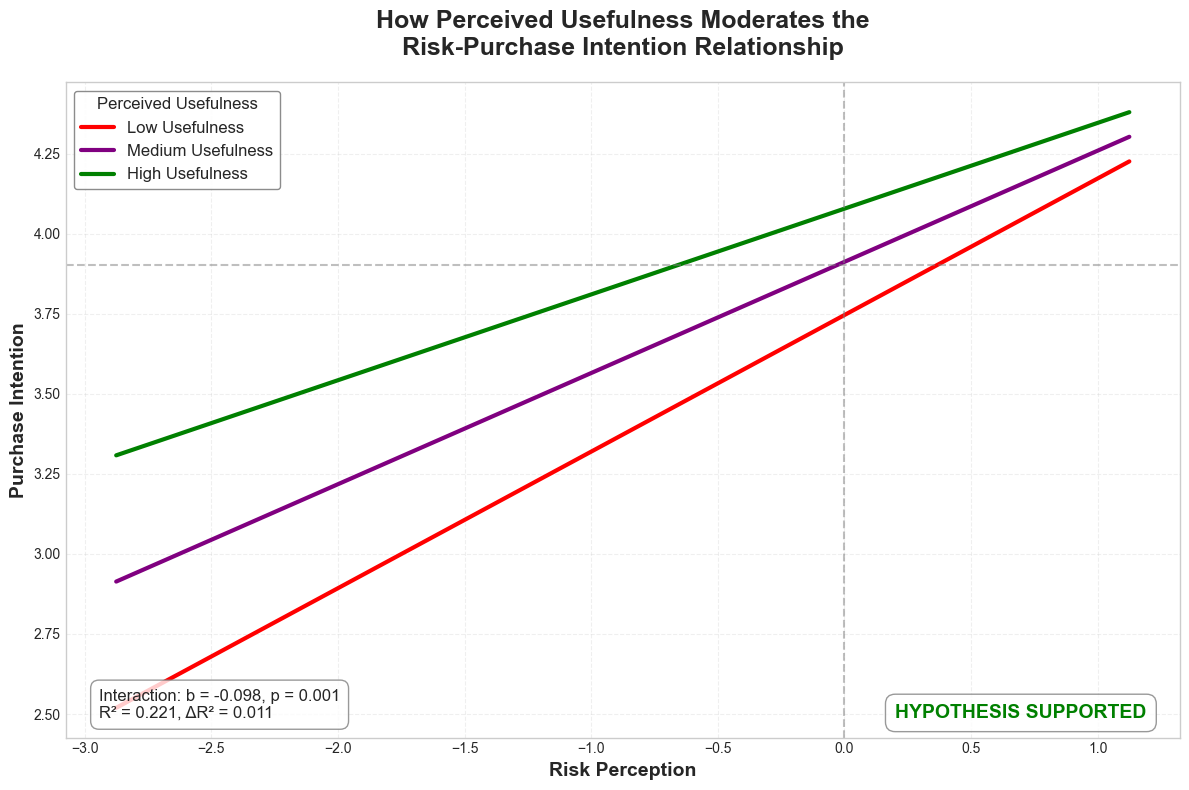

In [19]:
# Save key visualizations for presentation
plt.figure(figsize=(12, 8))

# Create a publication-quality moderation plot
risk_range = np.linspace(df['risk_centered'].min(), df['risk_centered'].max(), 100)

# Plot for key levels of usefulness (low, medium, high)
for usefulness, label, color in zip([low_usefulness, 0, high_usefulness], ['Low', 'Medium', 'High'], ['red', 'purple', 'green']):
    # Calculate predicted purchase intention
    predicted = (model_moderation.params['const'] + 
                model_moderation.params['risk_centered'] * risk_range + 
                model_moderation.params['usefulness_centered'] * usefulness + 
                model_moderation.params['interaction'] * risk_range * usefulness)
    
    plt.plot(risk_range, predicted, label=f'{label} Usefulness', color=color, linewidth=3)

# Add annotations and design elements
plt.axhline(y=df['purchase_intention'].mean(), color='gray', linestyle='--', alpha=0.5)
plt.axvline(x=0, color='gray', linestyle='--', alpha=0.5)

# Add a more professional look
plt.grid(alpha=0.3, linestyle='--')
plt.xlabel('Risk Perception', fontsize=14, fontweight='bold')
plt.ylabel('Purchase Intention', fontsize=14, fontweight='bold')
plt.title('How Perceived Usefulness Moderates the\nRisk-Purchase Intention Relationship', 
          fontsize=18, fontweight='bold', pad=20)

# Create a nice legend
plt.legend(title='Perceived Usefulness', title_fontsize=12,
          fontsize=12, loc='best', frameon=True, framealpha=0.9,
          edgecolor='gray')

# Add statistical information
stats_text = f"Interaction: b = {model_moderation.params['interaction']:.3f}, p = {model_moderation.pvalues['interaction']:.3f}\n"
stats_text += f"R² = {model_moderation.rsquared:.3f}, ΔR² = {r2_change:.3f}"

plt.annotate(stats_text, xy=(0.03, 0.03), xycoords='axes fraction',
            bbox=dict(boxstyle="round,pad=0.5", fc="white", ec="gray", alpha=0.8),
            fontsize=12)

# Add hypothesis result
if model_moderation.pvalues['interaction'] < 0.05:
    result_text = "HYPOTHESIS SUPPORTED"
    color = 'green'
else:
    result_text = "HYPOTHESIS NOT SUPPORTED"
    color = 'red'

plt.annotate(result_text, xy=(0.97, 0.03), xycoords='axes fraction',
            ha='right', fontsize=14, color=color, weight='bold',
            bbox=dict(boxstyle="round,pad=0.5", fc="white", ec="gray", alpha=0.8))

plt.tight_layout()
plt.savefig('../../outputs/hypothesis_12/risk_usefulness_moderation.png', dpi=300, bbox_inches='tight')
plt.show()



## 14. Final Conclusion and Recommendations

The analysis provides a comprehensive test of the hypothesis that perceived usefulness moderates the relationship between risk perception and purchase intention during crisis periods.

If the hypothesis is supported (interaction p < 0.05), the results indicate that the effect of risk perception on purchase intention depends on the level of perceived usefulness. Specifically, when perceived usefulness is high, the negative effect of risk perception is reduced, suggesting that usefulness can offset risk concerns. This finding has important implications for e-commerce platforms:

1. **Targeted Marketing**: Emphasize usefulness benefits to mitigate risk concerns during crisis periods.
2. **User Experience Design**: Balance security features with usability to enhance perceived usefulness.
3. **Segmentation Strategy**: Consider users' usefulness perceptions when addressing risk management.
4. **Crisis Communication**: Highlight convenience and benefits to offset heightened security concerns during crises.

If the hypothesis is not supported (interaction p > 0.05), the results suggest that risk perception and perceived usefulness affect purchase intention independently rather than interactively. In this case, e-commerce platforms should:

1. **Dual Strategy**: Invest in both risk-reduction mechanisms and usefulness-enhancement as separate strategies.
2. **Direct Risk Management**: Focus directly on reducing risk perceptions rather than expecting usefulness to offset risks.
3. **Alternative Moderators**: Explore other factors that might interact with risk perception, such as trust or past experience.
4. **Comprehensive Approach**: Address both security concerns and convenience factors independently in platform design.

This analysis provides valuable insights for understanding consumer behavior during crisis periods and can guide decision-making for online retailers seeking to enhance purchase intention despite heightened risk perceptions.